# Imports

In [1]:
!pip install -U vit-keras

In [2]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 9.7 MB/s 


In [3]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from vit_keras import vit

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  1 18:06:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!mkdir /content/dataset

In [7]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 20
CLASS_COUNT = 2

# Model Setup

In [9]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2, 
                               horizontal_flip = True)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 657,
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


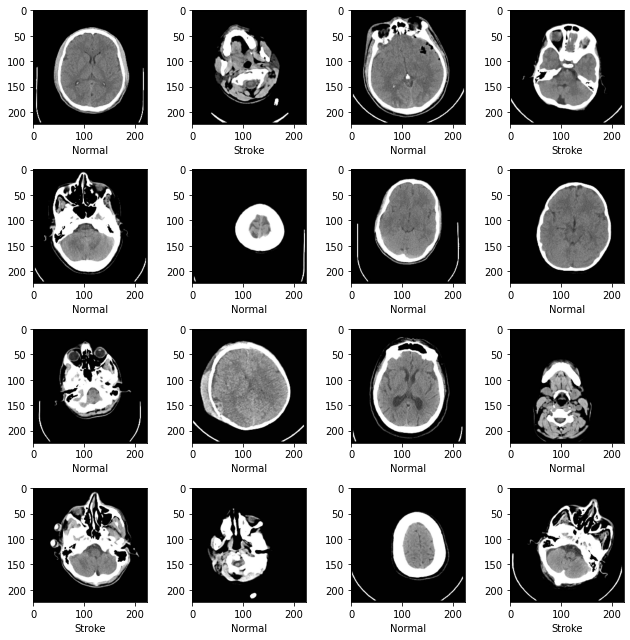

In [10]:
# show images from dataset
t_dict = train_set.class_indices
classes = list(t_dict.keys())  

images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(classes[label.astype(int)])
plt.tight_layout()
plt.show()

In [11]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# EfficientNetB2

## Build Model

In [61]:
IMAGE_SIZE = 350
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# create EfficientNetB2 base model
base_model = tf.keras.applications.EfficientNetB2(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling = 'max')

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate=.45, seed = 123)(x)        
predictions = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 350, 350, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 350, 350, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                            

In [63]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [64]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb2')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 15:45:44.932518


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 6.6252 - tp: 314.0000 - fp: 328.0000 - tn: 813.0000 - fn: 346.0000 - BinaryAccuracy: 0.6258 - precision: 0.4891 - recall: 0.4758 - auc: 0.6433
Epoch 00001: val_loss improved from inf to 6.22123, saving model to model.efficientnetb2.h5
57/57 [==============================] - 68s 924ms/step - loss: 6.6252 - tp: 314.0000 - fp: 328.0000 - tn: 813.0000 - fn: 346.0000 - BinaryAccuracy: 0.6258 - precision: 0.4891 - recall: 0.4758 - auc: 0.6433 - val_loss: 6.2212 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4923 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.8327 - tp: 413.0000 - fp: 224.0000 - tn: 917.0000 - fn: 247.0000 - BinaryAccuracy: 0.7385 - precision: 0.6484 - recall: 0.6258 - auc: 0.8052
Epoch 00002: val_loss improved from 6.22123 to 3.07941, saving mode

## Evaluate Model

In [65]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 133ms/step - loss: 0.7540 - tp: 105.0000 - fp: 42.0000 - tn: 243.0000 - fn: 60.0000 - BinaryAccuracy: 0.7733 - precision: 0.7143 - recall: 0.6364 - auc: 0.7770


In [66]:
# show results
print('EfficientNetB2:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB2:
---------------
ACCURACY: 0.7733333333333333
Binary Accuracy: 0.7733333110809326
Precision: 0.7142857313156128
Recall: 0.6363636255264282
AUC: 0.7769909501075745
F1 Score: 0.6730769245758562


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.87      0.87      0.87       125
      Stroke       0.87      0.86      0.87       125

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250

Confusion Matrix
[[109  16]
 [ 17 108]]


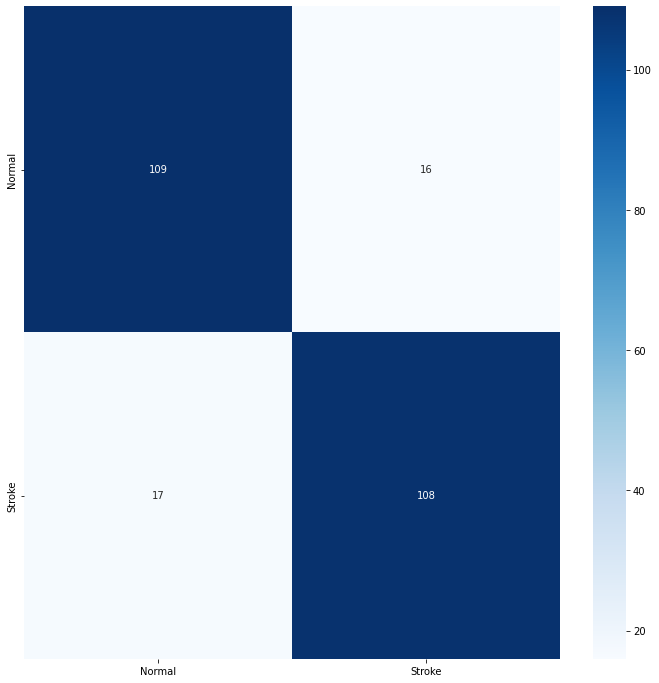

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# ViT B16

## Build Model

In [12]:
# build vit model with 16 patch_size
base_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate=.45, seed = 123)(x)        
predictions = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

347512832/347502902 [==============================] - 12s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [14]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

# model.compile(loss = 'binary_crossentropy', 
#               optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
#               metrics = metrics)

## Train Model

In [15]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 18:10:46.888382
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 5.7188 - tp: 239.0000 - fp: 336.0000 - tn: 805.0000 - fn: 421.0000 - BinaryAccuracy: 0.5797 - precision: 0.4157 - recall: 0.3621 - auc: 0.5447
Epoch 00001: val_loss improved from inf to 3.76391, saving model to model.vitb16.h5
57/57 [==============================] - 74s 899ms/step - loss: 5.7188 - tp: 239.0000 - fp: 336.0000 - tn: 805.0000 - fn: 421.0000 - BinaryAccuracy: 0.5797 - precision: 0.4157 - recall: 0.3621 - auc: 0.5447 - val_loss: 3.7639 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3935 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.0311 - tp: 314.0000 - fp: 209.0000 - tn: 932.0000 - fn: 346.0000 - BinaryAccuracy: 0.6918 - precision: 0.6004 - recall: 0.4758 - auc: 0.7007
Epoch 00002: val_loss improved from 3.76391 to 2

## Evaluate Model

In [16]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 4s 239ms/step - loss: 1.4082 - tp: 88.0000 - fp: 102.0000 - tn: 183.0000 - fn: 77.0000 - BinaryAccuracy: 0.6022 - precision: 0.4632 - recall: 0.5333 - auc: 0.6002


In [17]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.6022222222222222
Binary Accuracy: 0.602222204208374
Precision: 0.46315789222717285
Recall: 0.5333333611488342
AUC: 0.6001913547515869
F1 Score: 0.49577465846741403


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.65      0.86      0.74       125
      Stroke       0.80      0.54      0.65       125

    accuracy                           0.70       250
   macro avg       0.73      0.70      0.70       250
weighted avg       0.73      0.70      0.70       250

Confusion Matrix
[[108  17]
 [ 57  68]]


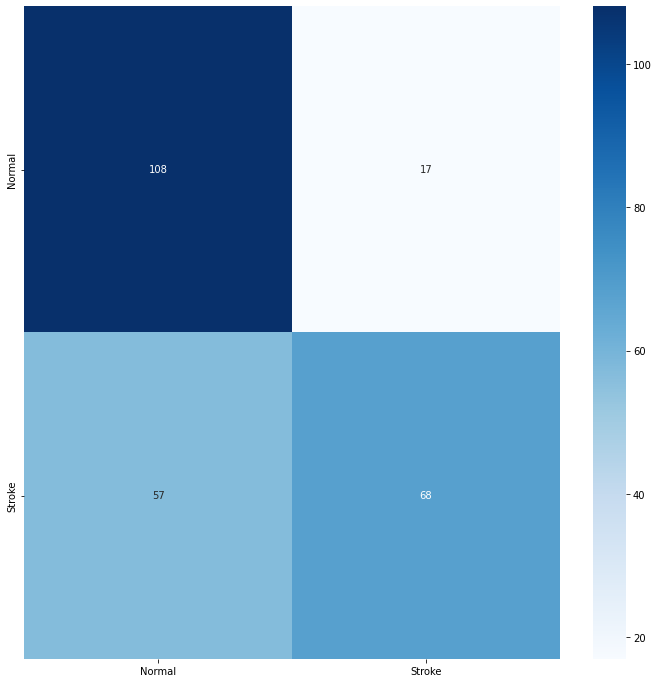

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

# ViT B32

## Build Model

In [45]:
# build vit model with 32 patch_size
base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate=.45, seed = 123)(x)        
predictions = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_7 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [46]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

# model.compile(loss = 'binary_crossentropy', 
#               optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999), 
#               metrics = metrics)

## Train Model

In [47]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-01 19:37:11.586189
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 5.7282 - tp: 203.0000 - fp: 295.0000 - tn: 846.0000 - fn: 457.0000 - BinaryAccuracy: 0.5825 - precision: 0.4076 - recall: 0.3076 - auc: 0.5276
Epoch 00001: val_loss improved from inf to 3.87536, saving model to model.vitb32.h5
57/57 [==============================] - 37s 363ms/step - loss: 5.7282 - tp: 203.0000 - fp: 295.0000 - tn: 846.0000 - fn: 457.0000 - BinaryAccuracy: 0.5825 - precision: 0.4076 - recall: 0.3076 - auc: 0.5276 - val_loss: 3.8754 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 3.1574 - tp: 166.0000 - fp: 244.0000 - tn: 897.0000 - fn: 494.0000 - BinaryAccuracy: 0.5902 - precision: 0.4049 - recall: 0.2515 - auc: 0.5342
Epoch 00002: val_loss improved from 3.87536 to 2

## Evaluate Model

In [48]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 1s 91ms/step - loss: 1.2015 - tp: 76.0000 - fp: 43.0000 - tn: 242.0000 - fn: 89.0000 - BinaryAccuracy: 0.7067 - precision: 0.6387 - recall: 0.4606 - auc: 0.6825


In [49]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.7066666666666667
Binary Accuracy: 0.7066666483879089
Precision: 0.6386554837226868
Recall: 0.46060606837272644
AUC: 0.6824561953544617
F1 Score: 0.5352112804117348


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.73      0.97      0.83       125
      Stroke       0.95      0.64      0.77       125

    accuracy                           0.80       250
   macro avg       0.84      0.80      0.80       250
weighted avg       0.84      0.80      0.80       250

Confusion Matrix
[[121   4]
 [ 45  80]]


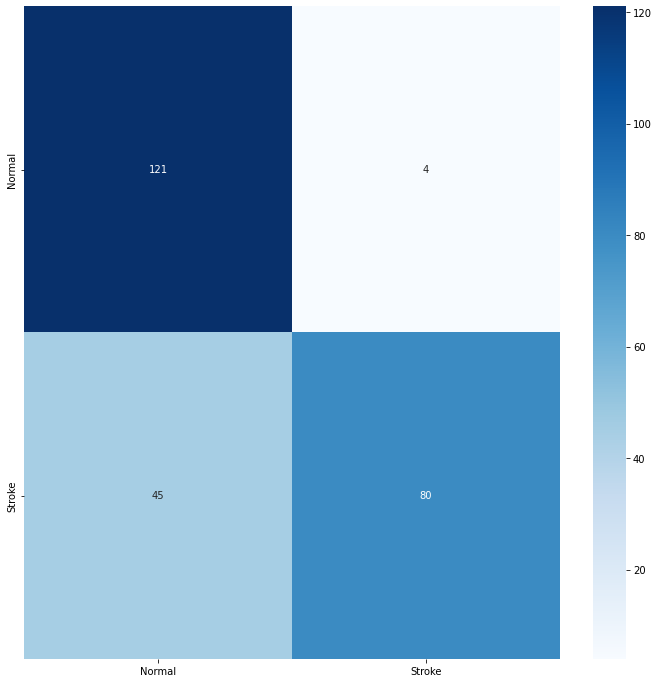

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)